# Malware detection from PCAP Network Captures

> This is a project to detect malware from PCAP network captures. 

In [ ]:
#| default_exp core

In [1]:
#| hide
from nbdev.showdoc import *

In [2]:
%load_ext autoreload
%autoreload 2

In [167]:
"""PCAP parser

'pparser' parses pcaps to flow features by Scapy.

"""
import ipaddress
from collections import OrderedDict
from datetime import datetime

import netaddr
import numpy as np
import pandas as pd
from scapy.layers.inet import IP, TCP, UDP, ICMP
from scapy.all import *


def _get_fid(pkt):
    """Extract fid (five-tuple) from a packet: only focus on IPv4
    Parameters
    ----------

    Returns
    -------
        fid: five-tuple
    """

    if IP in pkt and TCP in pkt:
        fid = (pkt[IP].src, pkt[IP].dst, pkt[TCP].sport, pkt[TCP].dport, 6)
    elif IP in pkt and UDP in pkt:
        fid = (pkt[IP].src, pkt[IP].dst, pkt[UDP].sport, pkt[UDP].dport, 17)
    else:  # others
        fid = ('', '', -1, -1, -1)

    return fid

def _get_frame_time(pkt):
    return float(pkt.time)


def flow_duration(pkts: List) -> float:
    
    pkt_times = [float(pkt.time) for pkt in pkts]
    flow_duration = max(pkt_times) - min(pkt_times)
    return flow_duration
    


def _pcap2flows(pcap_file, 
                flow_pkts_thres=2, 
                *, 
                tcp_timeout=600, 
                udp_timeout=600, 
                verbose=0):
    """Extract flows. Only keep TCP and UDP flows, others are discarded.

    Parameters
    ----------
    pcap_file: str
        a pcap needed to processed.

    flow_pkts_thres: int (default is 2)
        the minimum number of packets of each flow is to control which flow should be kept
        and which one should be discarded. The default value is 2, i.e., all the flows which have less than 2 packets
        are discarded. It must be >= 2.

    tcp_timeout: int (default is 600s)
        a timeout is to split flow

    ucp_timeout: int (default is 600s)
        a timeout is to split flow

    verbose: int (default is 1)
        a print level is to control what information should be printed according to the given value.
        The higher the value is, the more info is printed.

    Returns
    -------
        flows: list

    """

    if verbose:
        print(f'pcap_file: {pcap_file}')

    # store all extracted flows into a dictionary, whose key is flow id ('fid': five-tuple) and value is packtes
    # that belongs to the flow.
    flows = OrderedDict()
    try:
        # iteratively get each packet from the pcap
        for i, pkt in enumerate(PcapReader(pcap_file)):
            if (TCP in pkt) or (UDP in pkt):

                # this function treats bidirection flows as two sessions (hereafter, we use sessions
                # and flows interchangeably).
                fid = _get_fid(pkt)

                if fid not in flows.keys():
                    flows[fid] = [pkt]
                else:
                    flows[fid].append(pkt)
            else:
                continue

    except Exception as e:
        msg = f'Parse PCAP error: {e}!'
        raise RuntimeError(msg)

    if verbose > 3:
        print(f'len(flows): {len(flows.keys())}')

    # split flows by TIMEOUT and discard flows that have less than "flow_pkts_thres" packets.
    n_pkts = 0
    new_flows = []  # store the preprocessed flows
    for i, (fid, pkts) in enumerate(flows.items()):
        n_pkts += len(pkts)
        if len(pkts) < max(2, flow_pkts_thres):
            # discard flows that have less than "max(2, flow_pkts_thres)" packets
            continue

        # Is it necessary to sort packets by arrival_times?
        pkts = sorted(pkts, key=_get_frame_time, reverse=False)

        subflows = []
        # split flows by TIMEOUT
        for j, pkt in enumerate(pkts):
            pkt_time = _get_frame_time(pkt)
            if j == 0:
                subflow_tmp = [pkt]
                split_flow = False  # if a flow is not split with interval, label it as False, otherwise, True
                continue
            # print(fid, pkt)
            if (6 in fid) or (TCP in pkt):
                # handle TCP packets, TCP is 6
                # a timeout (the idle time) is the duration between the previous pkt and the current one.
                if pkt_time - _get_frame_time(subflow_tmp[-1]) > tcp_timeout:
                    # Note: here subflow_tmp will only have 1 packet
                    subflows.append((fid, subflow_tmp))
                    subflow_tmp = [pkt]  # create a new subflow and store the current packet as the first packet of it.
                    split_flow = True
                else:
                    subflow_tmp.append(pkt)
            elif (17 in fid) or UDP in pkt:
                # handle UDP packets, UDP is 17
                if pkt_time - _get_frame_time(subflow_tmp[-1]) > udp_timeout:
                    # print(fid, len(subflow_tmp))
                    # Note: here subflow_tmp will only have 1 packet
                    # E.g., without timeout splitting, the flow has two packets, pkt1 (time=2020-08-06 11:01:20.029699)
                    # and pkt2 (time=2020-08-07 01:01:20.376141), so after timeout splitting, subflow_tmp = [pkt1]
                    # (only one packet)
                    subflows.append((fid, subflow_tmp))
                    subflow_tmp = [pkt]
                    split_flow = True
                else:
                    subflow_tmp.append(pkt)
            else:  # it's not possible, because flows only include TCP and UDP flows
                pass

        # if the current flow is not split by TIMEOUT, then add it into subflows
        if not split_flow:
            subflows.append((fid, subflow_tmp))
        else:
            # discard the last subflow_tmp
            pass

        new_flows.extend(subflows)

    new_flows = [(fid, pkts) for (fid, pkts) in new_flows if len(pkts) >= flow_pkts_thres]
    if verbose > 3:
        n_lt_2 = len([len(pkts) for fid, pkts in flows.items() if len(pkts) < flow_pkts_thres])
        n_gt_2 = len([len(pkts) for fid, pkts in flows.items() if len(pkts) >= flow_pkts_thres])
        print(f'total number of flows: {len(flows.keys())}. Num of flows < {flow_pkts_thres} pkts: {n_lt_2}, '
              f'and >={flow_pkts_thres} pkts: {n_gt_2} without timeout splitting.')
        print(
            f'kept flows: {len(new_flows)}. Each of them has at least {flow_pkts_thres} pkts after timeout splitting.')

    return new_flows


def _flows2subflows(flows, interval=10, *, flow_pkts_thres=2, verbose=1):
    """Split flows to subflows by interval

    Parameters
    ----------
    flows: list
      all flows needed to be split

    interval: float (default is 5.0s)
       a window is to split each flow

    flow_ptks_thres: int (default is 2)
        the minimum number of packets of each flow is to control which flow should be kept
        and which one should be discarded. The default value is 2, i.e., all the flows which have less than 2 packets
        are discarded. It must be >= 2.

    verbose: int (default is 1)
        a print level is to control what information should be printed according to the given value.
        The higher the value is, the more info is printed.

    Returns
    -------
    subflows: list
        each of subflow has at least "flow_ptks_thres" packets
    """

    new_flows = []  # store all subflows
    for i, (fid, pkts) in enumerate(flows):
        if (verbose > 3) and (i % 1000) == 0:
            print(f'{i}th_flow: len(pkts): {len(pkts)}')

        # Is it necessary to sort packets by arrival_times ?
        pkts = sorted(pkts, key=_get_frame_time, reverse=False)

        subflows = []
        # split flows by interval
        for j, pkt in enumerate(pkts):
            pkt_time = _get_frame_time(pkt)
            if j == 0:
                subflow_tmp_start_time = pkt_time
                subflow_tmp = [(subflow_tmp_start_time, pkt)]
                split_flow = False  # if a flow is not split with interval, label it as False, otherwise, True
                continue

            if (6 in fid) or (TCP in pkt):
                # handle TCP packets, TCP is 6
                # a timeout (the idle time) is the duration between the previous pkt and the current one.
                if pkt_time - subflow_tmp[-1][0] > interval:
                    subflows.append((fid, subflow_tmp))
                    subflow_tmp_start_time += int((pkt_time - subflow_tmp_start_time) // interval) * interval
                    # create a new subflow and store "subflow_tmp_start_time" as the time. Here, it will has a tiny
                    # difference of packet time between "subflow_tmp_start_time" and the current packet time.
                    subflow_tmp = [(subflow_tmp_start_time, pkt)]
                    split_flow = True
                else:
                    subflow_tmp.append((pkt_time, pkt))

            elif (17 in fid) or UDP in pkt:
                # handle UDP packets, UDP is 17
                if pkt_time - subflow_tmp[-1][0] > interval:
                    subflows.append((fid, subflow_tmp))
                    subflow_tmp_start_time += int((pkt_time - subflow_tmp_start_time) // interval) * interval
                    subflow_tmp = [(subflow_tmp_start_time, pkt)]
                    split_flow = True
                else:
                    subflow_tmp.append((pkt_time, pkt))
            else:  # it's not possible, because flows only include TCP and UDP flows
                pass

        # if the current flow is not split by interval, then add it into subflows
        if not split_flow:
            subflows.append([fid, subflow_tmp])
        else:
            # discard the last subflow_tmp
            pass

        new_flows.extend(subflows)

    # sort all flows by packet arrival time, each flow must have at least two packets
    subflows = []
    for fid, subflow_tmp in new_flows:
        if len(subflow_tmp) < max(2, flow_pkts_thres):
            continue
        subflows.append((fid, [pkt for pkt_time, pkt in subflow_tmp]))

    new_flows = subflows
    if verbose > 1:
        print(f'After splitting flows, the number of subflows: {len(new_flows)} and each of them has at least '
              f'{flow_pkts_thres} packets.')

    return new_flows


def _get_header_features(flows):

    def _parse_tcp_flgs(tcp_flgs):
        # flags = {
        #     'F': 'FIN',
        #     'S': 'SYN',
        #     'R': 'RST',
        #     'P': 'PSH',
        #     'A': 'ACK',
        #     'U': 'URG',
        #     'E': 'ECE',
        #     'C': 'CWR',
        # }
        flgs = {
            'F': 0,
            'S': 1,
            'R': 2,
            'P': 3,
            'A': 4,
            'U': 5,
            'E': 6,
            'C': 7,
        }

        flg_counts = np.zeros(8)
        for flg in tcp_flgs:
            if flg in flgs.keys():
                flg_counts[flgs[flg]] += 1

        return flg_counts

    features = []
    for fid, pkts in flows:
        flgs_lst = np.zeros(8)  # 8 TCP flags
        header_features = []
        for i, pkt in enumerate(pkts):
            if not hasattr(pkt.payload, 'proto'):
                continue
            if pkt.payload.proto == 6:  # tcp
                flgs_lst += _parse_tcp_flgs(pkt.payload.payload.flags) # parses tcp.flgs
            # TODO: figure out this ttl part
            #header_features.append(pkt.payload.ttl)
        features.append(flgs_lst)

    return features


def _get_IAT(flows):
    """Extract interarrival times (IAT) features  from flows.
    Parameters
    ----------

    Returns
    -------
    features: a list
        iats
    fids: a list
        each value is five-tuple
    """
    features = []
    fids = []
    for fid, pkts in flows:
        pkt_times = [_get_frame_time(pkt) for pkt in pkts]
        # some packets have the same time, please double check the pcap.
        iats = list(np.diff(pkt_times))
        features.append(iats)
        fids.append(fid)

    return features, fids


def _get_SIZE(flows):
    """Extract packet sizes features from flows
    Parameters
    ----------

    Returns
    -------
    features: a list
        sizes
    fids: a list
        each value is five-tuple
    """

    features = []
    fids = []
    for fid, pkts in flows:
        sizes = [len(pkt) for pkt in pkts]
        features.append(sizes)
        fids.append(fid)

    return features, fids


def _get_IAT_SIZE(flows):
    """Extract iats and sizes features from flows
    Parameters
    ----------

    Returns
    -------
    features: a list
        iats_sizes
    fids: a list
        each value is five-tuple
    """

    features = []
    fids = []
    for fid, pkts in flows:
        pkt_times = [_get_frame_time(pkt) for pkt in pkts]
        iats = list(np.diff(pkt_times))
        sizes = [len(pkt) for pkt in pkts]
        iats_sizes = []
        for j in range(len(iats)):
            iats_sizes.extend([iats[j], sizes[j]])
        iats_sizes.append(sizes[-1])
        features.append(iats_sizes)
        fids.append(fid)

    return features, fids


def _get_STATS(flows):
    """get basic stats features, which includes duration, pkts_rate, bytes_rate, mean,
    median, std, q1, q2, q3, min, and max.

    Parameters
    ----------
    flows:

    Returns
    -------
    features: a list
        stats
    fids: a list
        each value is five-tuple
    """

    features = []
    fids = []
    for fid, pkts in flows:
        sizes = [len(pkt) for pkt in pkts]

        sub_duration = flow_duration(pkts)
        num_pkts = len(sizes)  # number of packets in the flow
        num_bytes = sum(sizes)  # all bytes in sub_duration  sum(len(pkt))
        if sub_duration == 0:
            pkts_rate = 0.0
            bytes_rate = 0.0
        else:
            pkts_rate = num_pkts / sub_duration  # it will be very larger due to the very small sub_duration
            bytes_rate = num_bytes / sub_duration

        q1, q2, q3 = np.quantile(sizes, q=[0.25, 0.5, 0.75])  # q should be [0,1] and q2 is np.median(data)
        base_features = [sub_duration, pkts_rate, bytes_rate, np.mean(sizes), np.std(sizes),
                         q1, q2, q3, np.min(sizes), np.max(sizes), num_pkts, num_bytes]

        features.append(base_features)

        fids.append(fid)

    return features, fids


def _get_SAMP(flows, sampling_feature='SAMP_NUM', sampling_rate=0.1, verbose=1):
    """Extract sampling IATs from subwindows obtained by splitting each flow.

    For example, sampling_feature = 'SAMP_NUM'
        The length in time of the sub window is what we’re calling sampling rate.
           features obtained on sampling_rate = 0.1 means that:
            1) split each flow into small windows, each window has 0.1 duration (the length in time of each small window)
            2) obtain the number of packets from each window (0.1s).
            3) all the values obtained form each window make up of the features (SAMP_NUM).

    Parameters
    ----------
    flows: list
        all flows.

    sampling_feature: str
        'SAMP_NUM' or 'SAMP_SIZE'
        the feature we wants to extract from each flow.

    sampling_rate: float
        the duration of the window

    Returns
    -------

    features: a list
       SAMP features

    fids: a list
        each value is five-tuple

    """
    features = []
    fids = []
    for fid, pkts in flows:
        # for each flow
        each_flow_features = []
        pkt_times = [_get_frame_time(pkt) for pkt in pkts]
        pkt_sizes = [len(pkt) for pkt in pkts]
        samp_sub = -1
        for i in range(len(pkts)):
            if i == 0:
                current = pkt_times[0]
                if sampling_feature == 'SAMP_NUM':
                    samp_sub = 1
                elif sampling_feature == 'SAMP_SIZE':
                    samp_sub = pkt_sizes[0]
                continue
            if pkt_times[i] - current <= sampling_rate:  # interval
                if sampling_feature == 'SAMP_NUM':
                    samp_sub += 1
                elif sampling_feature == 'SAMP_SIZE':
                    samp_sub += pkt_sizes[i]
                else:
                    print(f'{sampling_feature} is not implemented yet')
            else:  # if times[i]-current > sampling_rate:    # interval
                current += sampling_rate
                each_flow_features.append(samp_sub)
                # the time diff between times[i] and times[i-1] will be larger than mutli-samplings
                # for example, times[i]=10.0s, times[i-1]=2.0s, sampling=0.1,
                # for this case, we should insert int((10.0-2.0)//0.1) * [0]
                num_intervals = int(np.floor((pkt_times[i] - current) // sampling_rate))
                if num_intervals > 0:
                    num_intervals = min(num_intervals, 500)
                    each_flow_features.extend([0] * num_intervals)
                    current += num_intervals * sampling_rate
                if len(each_flow_features) > 500:  # avoid num_features too large to excess the memory.
                    # return fid, each_flow_features[:500]
                    samp_sub = -1
                    each_flow_features = each_flow_features[:500]
                    break

                if sampling_feature == 'SAMP_NUM':
                    samp_sub = 1
                elif sampling_feature == 'SAMP_SIZE':
                    samp_sub = pkt_sizes[i]

        if samp_sub > 0:  # handle the last sub period in the flow.
            each_flow_features.append(samp_sub)

        features.append(each_flow_features)
        fids.append(fid)

    # if verbose:
    #     show_len = 10  # only show the first 20 difference
    #     samp_lens = np.asarray([len(samp_features) for samp_features in features])[:show_len]

    return features, fids


def _get_SAMP_NUM(flows, sampling_rate=1):
    """Extract sampling the number of packets from subwindows obtained by splitting each flow.

     The length in time of the sub window is what we’re calling sampling rate.
        features obtained on sampling_rate = 0.1 means that:
         1) split each flow into small windows, each window has 0.1 duration (the length in time of each small window)
         2) obtain the number of packets from each window (0.1s).
         3) all values obtained from each window make up of the features (SAMP_NUM).

    Parameters
    ----------
        flows: list

        sampling_rate: float
           the duration of subwindow (interval)
    Returns
    -------
    features: a list
        sizes
    fids: a list
        each value is five-tuple
    """

    features, fids = _get_SAMP(flows, sampling_feature='SAMP_NUM', sampling_rate=sampling_rate)

    return features, fids


def _get_SAMP_SIZE(flows, sampling_rate=1):
    """Extract sampling total sizes of packets from each subwindow after splitting each flow.

     The length in time of the subwindow is what we’re calling sampling rate.
        features obtained on sampling_rate = 0.1 means that:
         1) split each flow into small windows, each window has 0.1 duration (the length in time of each small window)
         2) obtain the total size of packets in each window (0.1s).
         3) all the values obtained from each window make up of the features (SAMP_SIZE).

    Parameters
    ----------
        flows:list

        sampling_rate: float
           the duration of subwindow (interval)

    Returns
    -------
    features: a list
        sizes
    fids: a list
        each value is five-tuple
    """
    features, fids = _get_SAMP(flows, sampling_feature='SAMP_SIZE', sampling_rate=sampling_rate)

    return features, fids


def _get_split_interval(flow_durations, q_interval=0.9):
    interval = np.quantile(flow_durations, q=q_interval)
    return interval


def _get_FFT_data(features, fft_bin='', fft_part='real'):
    """Do fft transform of features

    Parameters
    ----------
    features: features

    fft_bin: int
        the dimension of transformed features
    fft_part: str
        'real' or 'real+imaginary' transformation

    Returns
    -------
    fft_features: a list
        transformed fft features
    """
    if fft_part == 'real':  # default
        fft_features = [list(np.real(np.fft.fft(v, n=fft_bin))) for v in features]

    elif fft_part == 'real+imaginary':
        msg = f'{fft_part}'
        raise NotImplementedError(msg)

    else:
        msg = f'fft_part: {fft_part} is not correct, please modify it and retry!'
        raise ValueError(msg)

    return fft_features


class PCAP:

    def __init__(self, pcap_file, *, flow_ptks_thres=2, verbose=0, random_state=42):
        """PCAP includes all processing functions of pcaps, such as pcap2flows, flow2features, and label_flows .

        Parameters
        ----------
        pcap_file: str
            a pcap needed to processed.

        flow_ptks_thres: int (default is 2)
            the minimum number of packets of each flow is to control which flow should be kept
            and which one should be discarded. The default value is 2, i.e., all the flows which have less than 2 packets
            are discarded. It must be >= 2.

        verbose: int (default is 1)
            a print level is to control what information should be printed according to the given value.
            The higher the value is, the more info is printed.

        random_state: int
            a value is to make your experiments more reproducible.

        Returns
        -------
            a PCAP instance

        """
        self.pcap_file = pcap_file
        self.flow_ptks_thres = flow_ptks_thres
        self.verbose = verbose
        self.random_state = random_state

        self.labels = None
        self.df = None

    def pcap2flows(self, interval=0, q_interval=0.1, *, tcp_timeout=600, udp_timeout=600):
        """Extract flows from the given pcap and split each flow to subflow by "interval" or "q_interval".
                   It prefers to choose "interval" as the split measure if interval > 0; otherwise, use q_interval to find an interval.
                    q_interval must be in [0, 1]

        Parameters
        ----------
        interval: float (default is 0.)
            an time interval is used to split a flow.

        q_interval: float (default is 0.9)
           a quntile (must be in [0, 1]) is to obtain "interval" from all flow durations.

        tcp_timeout: int (default is 600s)
            a value is to split flow by tcp_timeout.

        udp_timeout: int (default is 600s)
            a value is to split flow by udp_timeout.

        Returns
        -------
        all flows: list
            each element in the list represents a flow, and each flow includes 2 values: flow id (five-tuple) and packets.
        """

        # extract all flows firstly and then split flows to subflows
        flows = _pcap2flows(self.pcap_file, self.flow_ptks_thres, tcp_timeout=tcp_timeout, udp_timeout=udp_timeout,
                            verbose=self.verbose)

        if interval > 0:
            self.interval = interval
        else:
            if q_interval > 0:
                self.q_interval = q_interval
                self.flow_durations = [flow_duration(pkts) for fid, pkts in flows]
                self.interval = _get_split_interval(self.flow_durations, q_interval=self.q_interval)

            else:
                msg = f'q_interval must be in [0, 1]! Current q_interval is {q_interval}.'
                raise ValueError(msg)

        self.flows = _flows2subflows(flows, self.interval, flow_pkts_thres=self.flow_ptks_thres, verbose=self.verbose)

        
    def flow2features(self, feat_type='IAT', *, fft=False, header=False):
        """Extract features from each flow according to feat_type, fft and header.

        Parameters
        ----------
        feat_type: str (default is 'IAT')
            which features do we want to extract from flows

        fft: boolean (default is False)
            if we need fft-features

        header: boolean (default is False)
            if we need header+features

        Returns
        -------
            self
        """
        self.feat_type = feat_type

        num_pkts = [len(pkts) for fid, pkts in self.flows]

        dim = int(np.floor(np.quantile(num_pkts, self.q_interval)))  # use the same q_interval to get the dimension

        if feat_type in ['IAT', 'FFT-IAT']:
            self.dim = dim - 1
            self.features, self.fids = _get_IAT(self.flows)
        elif feat_type in ['SIZE', 'FFT-SIZE']:
            self.dim = dim
            self.features, self.fids = _get_SIZE(self.flows)
        elif feat_type in ['IAT_SIZE', 'FFT-IAT_SIZE']:
            self.dim = 2 * dim - 1
            self.features, self.fids = _get_IAT_SIZE(self.flows)
        elif feat_type in ['STATS']:
            self.dim = 12
            self.features, self.fids = _get_STATS(self.flows)
        elif feat_type in ['SAMP_NUM', 'FFT-SAMP_NUM']:
            self.dim = dim - 1
            flow_durations = [flow_duration(pkts) for fid, pkts in self.flows]
            # To obtain different samp_features, you should change q_interval ((0, 1))
            sampling_rate = _get_split_interval(flow_durations, q_interval=0.3)
            self.features, self.fids = _get_SAMP_NUM(self.flows, sampling_rate)
        elif feat_type in ['SAMP_SIZE', 'FFT-SAMP_SIZE']:
            self.dim = dim - 1  # here the dim of "SAMP_SIZE" is dim -1, which equals to the dimension of 'SAMP_NUM'
            flow_durations = [flow_duration(pkts) for fid, pkts in self.flows]
            sampling_rate = _get_split_interval(flow_durations, q_interval=0.3)
            self.features, self.fids = _get_SAMP_SIZE(self.flows, sampling_rate)
        else:
            msg = f'feat_type ({feat_type}) is not correct! '
            raise ValueError(msg)

        if fft:
            self.features = _get_FFT_data(self.features, fft_bin=self.dim)
        else:
            # fix each flow to the same feature dimension (cut off the flow or append 0 to it)
            self.features = [v[:self.dim] if len(v) > self.dim else v + [0] * (self.dim - len(v)) for v in self.features]

        if header:
            _headers = _get_header_features(self.flows)
            h_dim = 8 + self.dim  # 8 TCP flags
            if fft:
                fft_headers = _get_FFT_data(_headers, fft_bin=h_dim)
                self.features = [h + f for h, f in zip(fft_headers, self.features)]
            else:
                # fix header dimension firstly
                headers = [h[:h_dim] if len(h) > h_dim else h + [0] * (h_dim - len(h)) for h in _headers]
                self.features = [h + f for h, f in zip(headers, self.features)]

        # change list to numpy array
        self.features = np.asarray(self.features, dtype=float)
        if self.verbose > 5:
            print(np.all(self.features >= 0))


    def _iter_pcap_dict(self):
        """Stream extracted dict mappings from PCAP file.

        Requires:
          self.pcap_file: string filepath of PCAP file

        Returns:
          Iterator of dicts with one dict per packet in pcap file.

            The dicts have the following key/value pairs:

              "time"      : time the packet was receieved in seconds since epoch
              "datetime"  : time the packet was received as a datetime object
              "length"    : length of packet in bytes
              "mac_src"   : source MAC address
              "mac_dst"   : destination MAC address
              "ip_src"    : source IP address
              "ip_dst"    : destination IP address
              "protocol"  : 'TCP', 'UDP', 'ICMP', or None
              "port_src"  : source port
              "port_dst"  : destination port
              "is_dns"    : True if packet is DNS packet, else False
              "dns_query" : string DNS query
              "dns_resp"  : string DNS response

        """
        with PcapReader(self.pcap_file) as pcap_reader:
            for pkt in pcap_reader:
                if Ether not in pkt:
                    continue

                pkt_dict = {
                    'time': pkt.time,
                    'datetime': datetime.fromtimestamp(int(pkt.time)),
                    'length': len(pkt),
                    'mac_dst': pkt[Ether].dst,
                    'mac_src': pkt[Ether].src,
                    'ip_dst': None,
                    'ip_src': None,
                    'protocol': None,
                    'port_dst': None,
                    'port_src': None,
                    'is_dns': False,
                    'dns_query': None,
                    'dns_resp': None,
                }

                if IP in pkt:
                    pkt_dict['ip_dst'] = pkt[IP].dst
                    pkt_dict['ip_src'] = pkt[IP].src

                if TCP in pkt:
                    pkt_dict['port_dst'] = pkt[TCP].dport
                    pkt_dict['port_src'] = pkt[TCP].sport
                    pkt_dict['protocol'] = 'TCP'
                elif UDP in pkt:
                    pkt_dict['port_dst'] = pkt[UDP].dport
                    pkt_dict['port_src'] = pkt[UDP].sport
                    pkt_dict['protocol'] = 'UDP'
                elif ICMP in pkt:
                    pkt_dict['protocol'] = 'ICMP'

                try:
                    if (dnsqr := pkt.getlayer(DNSQR)) is not None:
                        pkt_dict.update(
                            is_dns=True,
                            dns_query=(
                                dnsqr.qname.decode('utf-8')
                                if isinstance(dnsqr.qname, bytes)
                                else dnsqr.qname,
                            )
                        )

                    if (dnsrr := pkt.getlayer(DNSRR)) is not None:
                        pkt_dict.update(
                            is_dns=True,
                            dns_resp=(
                                dnsrr.rrname.decode('utf-8')
                                if isinstance(dnsrr.rrname, bytes)
                                else dnsrr.rrname,
                            )
                        )
                except UnicodeDecodeError:
                    print("Decode error with {pkt.summary()}")

                yield pkt_dict

    def pcap2pandas(self) -> pd.DataFrame:
        """Parse PCAP file into pandas DataFrame.

        Requires:
            self.pcap_file: string filepath of PCAP file

        Returns:
          DataFrame with one packet per row.
            column names are the keys from pcap_to_dict plus
            'ip_dst_int', 'ip_src_int', 'mac_dst_int', 'mac_dst_int'

        """
        self.df = pd.DataFrame(self._iter_pcap_dict())

        self.df['datetime'] = pd.to_datetime(self.df['datetime'])

        self.df['ip_dst_int'] = self.df['ip_dst'].apply(
            lambda x: None if x is None else int(ipaddress.ip_address(x)))

        self.df['ip_src_int'] = self.df['ip_src'].apply(
            lambda x: None if x is None else int(ipaddress.ip_address(x)))

        self.df['mac_dst_int'] = self.df['mac_dst'].apply(
            lambda x: None if x is None else int(netaddr.EUI(x)))

        self.df['mac_src_int'] = self.df['mac_src'].apply(
            lambda x: None if x is None else int(netaddr.EUI(x)))

        self.df['time_normed'] = self.df['time'].apply(lambda x: x - self.df.iloc[0]['time'])

        self.df.sort_index(axis=1, inplace=True)
        
        return self.df



## Exploratory Data Analysis

We begin by loading in the data and trying to gain some understanding of the data.

In [178]:
#| export

import pandas as pd
import numpy as np
from pathlib import Path
from typing import List, Dict, Any, Optional, Union


In [179]:
DATA_PATH = Path('../data')
MPATH = DATA_PATH / 'malware'
BPATH = DATA_PATH / 'benign'

malware_files = list(MPATH.glob('**/*.pcap'))
benign_files = list(BPATH.glob('**/*.pcap'))

In [169]:


def load_malware_pcap() -> pd.DataFrame:
    df = pd.DataFrame()
    for file in malware_files:
        pcap = PCAP(str(file), verbose=0)
        pcap.pcap2pandas()
        pdf = pcap.df
        pdf['capture'] = file.name
        pdf['label'] = 1.0
        df = pd.concat([df,pdf], ignore_index=True)
    return df

def load_benign_pcap() -> pd.DataFrame:
    df = pd.DataFrame()
    for file in benign_files:
        pcap = PCAP(str(file), verbose=0)
        pcap.pcap2pandas()
        pdf = pcap.df
        pdf['capture'] = file.name
        pdf['label'] = 0.0
        df = pd.concat([df,pdf], ignore_index=True)
    return df


In [73]:
# Load the data into Pandas DataFrames for quick analysis.
mdata = load_malware_pcap()
bdata = load_benign_pcap()

print(f"Malware data shape: {mdata.shape}, and benign data shape: {bdata.shape}")

Decode error with {pkt.summary()}
Malware data shape: (167242, 20), and benign data shape: (40916, 20)


In [41]:
mdata.capture.value_counts(normalize=True)

2023-03-07-Emotet-epoch4-infection-with-spambot-traffic-carved.pcap           0.451723
2023-01-16-IcedID-infection-with-Backonnect-and-VNC-and-Cobalt-Strike.pcap    0.150453
2023-03-18-Emotet-E5-infection-traffic.pcap                                   0.118959
2023-04-13-MetaStealer-C2-traffic.pcap                                        0.118702
2022-09-21-Astaroth-Guildma-infection.pcap                                    0.080901
2022-12-07-Bumblebee-infection-with-Cobalt-Strike.pcap                        0.039344
2022-01-04-Remcos-RAT-infection-traffic.pcap                                  0.033646
2023-01-05-Agent-Tesla-variant-traffic.pcap                                   0.006272
Name: capture, dtype: float64

In [42]:
mdata.protocol.value_counts(normalize=True)

TCP     0.989466
UDP     0.009907
ICMP    0.000627
Name: protocol, dtype: float64

In [43]:
bdata.protocol.value_counts(normalize=True)

UDP     0.552400
TCP     0.372389
ICMP    0.075211
Name: protocol, dtype: float64

In [83]:

mdata.groupby(["capture", "protocol"]).size().reset_index(name="Counts")


,capture,protocol,Counts
0,2022-01-04-Remcos-RAT-infection-traffic.pcap,TCP,5621
1,2022-01-04-Remcos-RAT-infection-traffic.pcap,UDP,6
2,2022-09-21-Astaroth-Guildma-infection.pcap,TCP,13232
3,2022-09-21-Astaroth-Guildma-infection.pcap,UDP,243
4,2022-12-07-Bumblebee-infection-with-Cobalt-Str...,TCP,6209
5,2022-12-07-Bumblebee-infection-with-Cobalt-Str...,UDP,249
6,2023-01-05-Agent-Tesla-variant-traffic.pcap,TCP,998
7,2023-01-05-Agent-Tesla-variant-traffic.pcap,UDP,41
8,2023-01-16-IcedID-infection-with-Backonnect-an...,TCP,24970
9,2023-01-16-IcedID-infection-with-Backonnect-an...,UDP,78


In [89]:
mdata.groupby(["capture", "port_dst"]).size().reset_index(name="Counts").sort_values(by='Counts',ascending=False).head(10)

,capture,port_dst,Counts
858,2023-03-07-Emotet-epoch4-infection-with-spambo...,465.0,16125
1949,2023-04-13-MetaStealer-C2-traffic.pcap,49825.0,12479
669,2023-01-16-IcedID-infection-with-Backonnect-an...,64823.0,8050
596,2023-01-16-IcedID-infection-with-Backonnect-an...,8080.0,7826
859,2023-03-07-Emotet-epoch4-infection-with-spambo...,587.0,7545
1947,2023-04-13-MetaStealer-C2-traffic.pcap,1775.0,7310
1117,2023-03-07-Emotet-epoch4-infection-with-spambo...,64234.0,6164
1081,2023-03-07-Emotet-epoch4-infection-with-spambo...,64164.0,6043
139,2022-09-21-Astaroth-Guildma-infection.pcap,49790.0,5885
1090,2023-03-07-Emotet-epoch4-infection-with-spambo...,64173.0,5562


In [90]:
mdata.groupby(["capture", "port_src"]).size().reset_index(name="Counts").sort_values(by='Counts',ascending=False).head(10)

,capture,port_src,Counts
868,2023-03-07-Emotet-epoch4-infection-with-spambo...,465.0,18848
2008,2023-04-13-MetaStealer-C2-traffic.pcap,1775.0,12529
869,2023-03-07-Emotet-epoch4-infection-with-spambo...,587.0,9234
606,2023-01-16-IcedID-infection-with-Backonnect-an...,8080.0,8390
679,2023-01-16-IcedID-infection-with-Backonnect-an...,64823.0,7557
2010,2023-04-13-MetaStealer-C2-traffic.pcap,49825.0,7253
19,2022-09-21-Astaroth-Guildma-infection.pcap,80.0,6610
870,2023-03-07-Emotet-epoch4-infection-with-spambo...,7080.0,6543
871,2023-03-07-Emotet-epoch4-infection-with-spambo...,8080.0,6437
1093,2023-03-07-Emotet-epoch4-infection-with-spambo...,64164.0,5213


In [44]:
mdata.describe()

,ip_dst_int,ip_src_int,length,mac_dst_int,mac_src_int,port_dst,port_src,label
count,1.657070e+05,1.657070e+05,167242.000000,1.672420e+05,1.672420e+05,165737.000000,165737.000000,167242.0
mean,1.637467e+09,1.809889e+09,712.858606,2.865872e+13,2.656908e+13,36881.798778,24398.298775,1.0
std,1.273197e+09,1.183365e+09,687.362543,6.278353e+13,5.474226e+13,27956.455094,27928.376870,0.0
min,9.897851e+07,0.000000e+00,42.000000,1.280447e+10,1.280447e+10,25.000000,25.000000,1.0
25%,1.685605e+08,6.237032e+08,54.000000,1.280447e+10,4.842871e+10,587.000000,465.000000,1.0
50%,1.738531e+09,1.746220e+09,207.000000,4.842871e+10,4.842871e+10,49825.000000,8080.000000,1.0
75%,2.886730e+09,2.886730e+09,1514.000000,2.683002e+13,2.683002e+13,64110.000000,51414.000000,1.0
max,4.294967e+09,3.681890e+09,1514.000000,2.814750e+14,2.134394e+14,65470.000000,65470.000000,1.0


In [45]:
bdata.describe()

,ip_dst_int,ip_src_int,length,mac_dst_int,mac_src_int,port_dst,port_src,label
count,2.712200e+04,2.712200e+04,40916.000000,4.091600e+04,4.091600e+04,29535.000000,29535.000000,40916.0
mean,2.384812e+09,2.342441e+09,288.795777,7.730433e+13,9.139651e+13,16415.411715,23833.567598,0.0
std,1.327534e+09,1.256641e+09,417.297590,9.085691e+13,8.904701e+13,21125.173308,24908.395456,0.0
min,1.684301e+07,0.000000e+00,42.000000,0.000000e+00,0.000000e+00,13.000000,13.000000,0.0
25%,1.418889e+09,1.418889e+09,80.000000,6.909339e+11,1.436246e+11,646.000000,631.000000,0.0
50%,3.232237e+09,3.232237e+09,126.000000,4.036557e+13,6.638738e+13,5690.000000,7078.000000,0.0
75%,3.239634e+09,3.232246e+09,226.000000,1.979643e+14,1.979643e+14,35192.000000,49268.000000,0.0
max,4.294967e+09,3.640661e+09,8814.000000,2.814750e+14,2.379405e+14,65535.000000,65535.000000,0.0


In [96]:
pcap_file = malware_files[1]
pp = PCAP(str(pcap_file), flow_ptks_thres=2)
pp.pcap2flows(q_interval=0.99)
feat_type = 'IAT'
pp.flow2features(feat_type, fft=False, header=False)

In [135]:
headers = _get_header_features(pp.flows)
np.array(headers).shape

(18, 8)

True


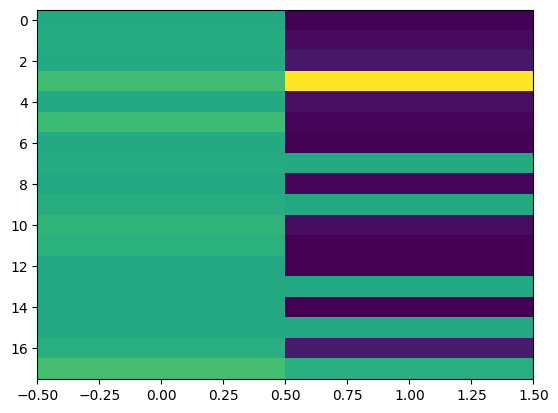

In [92]:
from matplotlib import pyplot as plt
# extract features from each flow given feat_type
pp.flow2features('IAT', fft=False, header=False)
plt.imshow(pp.features, aspect='auto');

In [62]:
pp.features.shape

(18, 4)

## Training a model

In [180]:


def collect_flow_stats(pcap_file: Path):
    pp = PCAP(str(pcap_file), flow_ptks_thres=2, verbose=0)
    pp.pcap2flows()
    pp.flow2features('STATS', fft=False, header=False)
    stats_features = pp.features
    pp.flow2features('IAT', fft=False, header=False)
    iat_mean = np.expand_dims(np.mean(pp.features, axis=1),1)
    iat_std = np.expand_dims(np.std(pp.features, axis=1),1)
    iat_median = np.expand_dims(np.median(pp.features, axis=1),1)
    iat_q1 = np.expand_dims(np.quantile(pp.features, 0.25, axis=1),1)
    iat_q3 = np.expand_dims(np.quantile(pp.features, 0.75, axis=1),1)
    
    # Ports from the flow 
    src_ports = np.array([str(flow[0][2]) for flow in pp.flows])
    dst_ports = np.array([str(flow[0][3]) for flow in pp.flows])
    protocol = np.array([str(flow[0][4]) for flow in pp.flows])
  
    src_ports = np.expand_dims(src_ports,1)
    dst_ports = np.expand_dims(dst_ports,1)
    protocol = np.expand_dims(protocol,1)
    
    # Headers from the flow
    
    headers_features =  _get_header_features(pp.flows)

    # Concatenate the features
    return np.hstack([stats_features,
                      iat_mean, 
                      iat_std, 
                      iat_median, 
                      iat_q1, 
                      iat_q3,
                      src_ports,
                      dst_ports,
                      protocol, headers_features])
    



In [181]:
features_names = [f"stats_{i}" for i in range(12) ]
features_names += ['iat_mean', 'iat_std', 'iat_median', 'iat_q1', 'iat_q3'] + ['src_port', 'dst_port', 'protocol'] + ['header_' + str(i) for i in range(8)]

In [182]:
print(benign_files)

[Path('../data/benign/benign.pcap'), Path('../data/benign/output.pcap'), Path('../data/benign/good.pcap')]


In [183]:

Xm = np.vstack([collect_flow_stats(f) for f in malware_files])
Xb = np.vstack([collect_flow_stats(f) for f in benign_files])
X = np.vstack([Xm, Xb])
y = np.array([1] * Xm.shape[0] + [0] * Xb.shape[0])
#assert(len(features_names) == X.shape[1])

Training set has 3829 samples.
Test set has 1642 samples.
Training set has 2571 malware samples.
Training set has 1258 legitimate samples.
Cross validation scores: [0.98302872 0.98302872 0.98302872 0.98172324 0.99084967]
Average cross validation score: 0.9843318145360843
Accuracy on training: 0.9997388352050144
Accuracy on test: 0.989646772228989
AUC: 0.9991185117625179
F1 score: 0.9923869234214062
Ten most important features
1. feature iat_q3 (0.169743)
2. feature iat_median (0.095644)
3. feature iat_mean (0.095146)
4. feature iat_q1 (0.078214)
5. feature stats_8 (0.077575)
6. feature stats_0 (0.075372)
7. feature header_4 (0.060690)
8. feature src_port (0.046531)
9. feature stats_1 (0.042471)
10. feature dst_port (0.035283)
[[ 517   12]
 [   5 1108]]


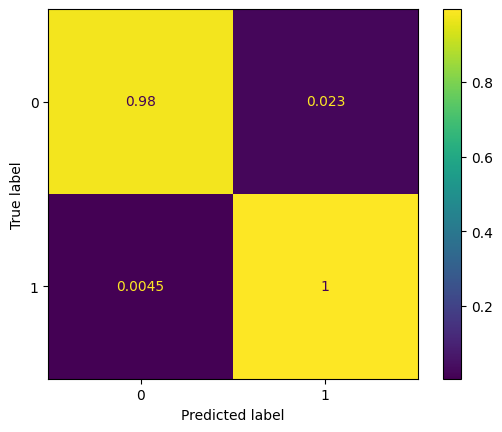

In [184]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Show the sizes of the training and test sets
print("Training set has {} samples.".format(X_train.shape[0]))
print("Test set has {} samples.".format(X_test.shape[0]))

# Show the balance of labels in the training and test sets
print("Training set has {} malware samples.".format(sum(y_train)))
print("Training set has {} legitimate samples.".format(len(y_train) - sum(y_train)))


# Instantiate model 
model = RandomForestClassifier(n_estimators = 30, max_depth=10)

scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross validation scores:", scores)
print("Average cross validation score:", np.mean(scores))

model.fit(X_train, y_train)

# Accuracy on training set
score = model.score(X_train, y_train)
print("Accuracy on training:", score)

# Show accuracy score
score = model.score(X_test, y_test)
print("Accuracy on test:", score)

# Show AUC score
print("AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

# Show the F1 score
from sklearn.metrics import f1_score
print("F1 score:", f1_score(y_test, model.predict(X_test)))


importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
print("Ten most important features")
for f in range(min(10, X_train.shape[1])):
    print("%d. feature %s (%f)" % (f + 1, features_names[indices[f]], importances[indices[f]]))

print(confusion_matrix(y_test, model.predict(X_test)))

# Plot the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize='true')
plt.show()

In [185]:

TPATH = DATA_PATH / 'test/malware'
test_files = list(TPATH.glob('**/*.pcap'))
Xt = np.vstack([collect_flow_stats(f) for f in test_files])
y_test2 = np.ones(Xt.shape[0])
accuracy = 1.0 - np.abs(model.predict(Xt) - y_test2).sum() / Xt.shape[0]
print(f"Accuracy on test set for malware: {accuracy:.2f}")




Accuracy on test set for malware: 0.99


In [187]:

TPATH = DATA_PATH / 'test/benign'
test_files = list(TPATH.glob('**/*.pcap'))
Xt = np.vstack([collect_flow_stats(f) for f in test_files])
print(Xt.shape)
y_test2 = np.zeros(Xt.shape[0])
accuracy = 1.0 - np.abs(model.predict(Xt) - y_test2).sum() / Xt.shape[0]
print(f"Accuracy on test set for benign traffic: {accuracy:.2f}")

(1383, 28)
Accuracy on test set for benign traffic: 0.91


## TODO List

* Clean this code up and create a proper package, adding comments and an actual flow. Explain the feature engineering components, model training and evaluation.
* MLOps: How to use elastic and a model, and feature registry, and model deployment.
* Dockerize the project 
* Add a detailed README.md to the project explaining the project and how to use it.
* Create an arch diagram for a elastic deployment. 

In [ ]:
#| hide


import nbdev; nbdev.nbdev_export()